In [9]:
import pandas as pd
import numpy as np
import seaborn as sns
from scipy.stats import stats
import itertools
import matplotlib.pyplot as plt
import cloveFunctions as clv


### comparing tcga to ccle
original implementation was in *ccle_results.ipynb*

### comparing cldeg to demeter (achillies)
original implementation was in *ccle_results.ipynb*

In [36]:
# generate clDEG (vulnerability vector) in CCLE breast cloves
exp = pd.read_pickle('data/breast_mrna_df.pickle')
cnv = pd.read_csv('data/breast_CCLE_DEL_calls.csv.gz', index_col=0, compression='gzip')
hits = pd.read_csv('data/breast_ttest_real_samp.tab.gz', sep='\t', index_col=0, compression='gzip')

cldeg_ccle = clv.vulnerability_vector_count(exp, cnv, hits)
# cldeg_ccle.to_csv('data/breast_het_clDEG_count.tab.gz', sep='\t', compression='gzip')
dep_breast = pd.read_csv('data/breast_Achilles_gene_dependency.csv.gz', compression='gzip', index_col=0)

corr = clv.correlate_df_cols(cldeg_ccle, dep_breast)
# corr_null = clv.correlate_df_cols(cldeg_ccle, dep_breast,perm=True)

corr_null['group']='null'
corr['group']='non-null'
corr_cat = pd.concat([corr_null, corr])
# corr_cat.to_csv('data/breast_clDEG_ccleVdemeter_cells.tab', sep='\t')

Ks_2sampResult(statistic=0.42307692307692307, pvalue=0.012812361957881577)


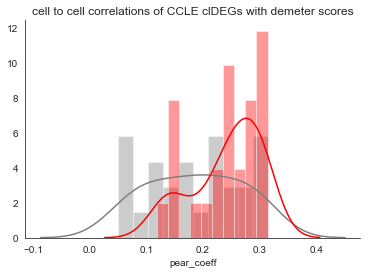

In [42]:
%matplotlib inline
sns.set_style("white")
sns.distplot(corr_cat[corr_cat['group']=='null']['pear_coeff'], color='gray',kde=True, norm_hist=True,bins=10)

sns.distplot(corr_cat[corr_cat['group']=='non-null']['pear_coeff'], color='red',kde=True,norm_hist=True,bins=10)
plt.title('cell to cell correlations of CCLE clDEGs with demeter scores')
sns.despine()

print(stats.ks_2samp(corr_null['pear_coeff'], corr['pear_coeff']))

In [ ]:
cldeg_tcga = pd.read_csv('data/brca_het_clDEG_count.tab.gz', sep='\t', compression='gzip', index_col=0)

In [97]:
cldeg = cldeg_tcga
cldeg.min().min()
very_null = pd.DataFrame(np.random.randint(cldeg.min().min(),cldeg.max().max(),size=(cldeg.shape[0], cldeg.shape[1])), 
                         columns=cldeg.columns, index=cldeg.index)

corr = clv.correlate_df_cols(cldeg_tcga, dep_breast, comb=True)
corr_null = clv.correlate_df_cols(very_null, dep_breast,comb=True)


In [75]:
corr_cat = pd.read_csv('data/breast_clDEG_ccleVdemeter_cells.tab', sep='\t', index_col=0)

Ks_2sampResult(statistic=0.99285611199307267, pvalue=0.0)


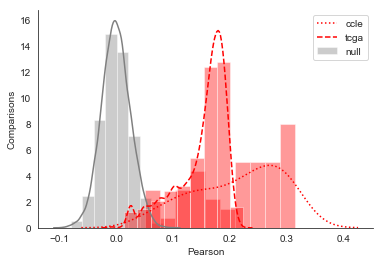

In [101]:
null_samp = corr_null.sample(corr.shape[0])
null_samp['pear_coeff']=null_samp['pear_coeff']*3.3
%matplotlib inline
sns.set_style("white")

sns.distplot(null_samp['pear_coeff'], color='gray',kde=True, norm_hist=True,bins=10, label='null')

sns.distplot(corr_cat['pear_coeff'].dropna(), color='red',kde=True,kde_kws={'linestyle':':', 'label':'ccle'},norm_hist=True,bins=10)

sns.distplot(corr['pear_coeff'].dropna(), color='red',kde=True,kde_kws={'linestyle':'--', 'label':'tcga'},norm_hist=True,bins=10)
plt.title('')
sns.despine()
plt.xlabel('Pearson')
plt.ylabel('Comparisons')
plt.legend()

print(stats.ks_2samp(corr_null['pear_coeff'], corr['pear_coeff']))

In [67]:
pd.merge(left=corr_null, right=corr, left_on=['sample','cell'], right_on=['sample','cell']).dropna().shape

(26182, 6)

Ks_2sampResult(statistic=0.053254437869822535, pvalue=0.067450291984364558)


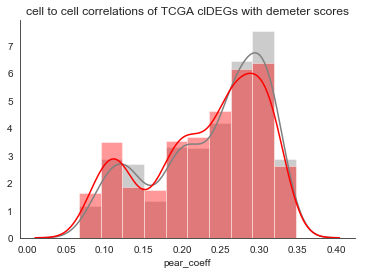

In [45]:
%matplotlib inline
sns.set_style("white")
sns.distplot(corr_null['pear_coeff'], color='gray',kde=True, norm_hist=True,bins=10)

sns.distplot(corr['pear_coeff'], color='red',kde=True,norm_hist=True,bins=10)
plt.title('cell to cell correlations of TCGA clDEGs with demeter scores')
sns.despine()
plt.legend()

print(stats.ks_2samp(corr_null['pear_coeff'], corr['pear_coeff']))

## Sanity check: DepMap vs Demeter
confirm that DepMap Essentiality calls have higher Demeter Essentiality scores (in agreement)

In [7]:
# load data
depmap = pd.read_table('data/depmap_binaryDepScores.tsv.zip', index_col=0)
demetr = pd.read_csv('data/breast_Achilles_gene_dependency.csv.gz', index_col=0)
ccle = pd.read_csv('data/breast_ttest_nonull_n2v8.tab.gz', sep='\t', index_col=0)
breastlines = pd.read_csv('data/breast_mrna.tab.gz', sep='\t', index_col=0).columns

essential vs nonessential Ttest_indResult(statistic=141.00423051057214, pvalue=0.0)
essential vs nonessential Ks_2sampResult(statistic=0.77580586743933355, pvalue=0.0)


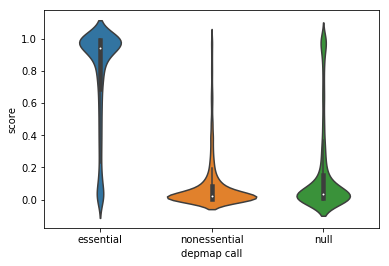

In [71]:
# begin validating depmap calls and demeter
# do they correlate?
depvalid = depmap[list(set(depmap.columns).intersection(demetr.columns))] 
demvalid = demetr[list(set(depmap.columns).intersection(demetr.columns))] 
depnull = depvalid.sample(frac=1).set_index(depvalid.index, drop=True)

#get demeter scores that are depmap-essential
essential = demvalid[depvalid ==1].values.flatten() # dep-essential
essential = essential[~np.isnan(essential)]
nonessential= demvalid[depvalid ==0].dropna().values # dep-nonessential
nonessential = nonessential[~np.isnan(nonessential)]
null = demvalid[depnull ==1].values.flatten()  # dep-nullessential
null = null[~np.isnan(null)]

rownum = min(len(essential), len(nonessential))
essential=np.random.choice(essential, rownum)
nonessential=np.random.choice(nonessential, rownum)
null=np.random.choice(null, rownum)
print('essential vs nonessential', scipy.stats.ttest_ind(essential, nonessential))
print('essential vs nonessential', scipy.stats.ks_2samp(essential, nonessential))


depmap_demeter_df = pd.concat([pd.DataFrame({'score':null, 'depmap call': 'null'}),
           pd.DataFrame({'score':essential, 'depmap call': 'essential'}),
           pd.DataFrame({'score':nonessential, 'depmap call': 'nonessential'})])
                    
%matplotlib inline
sns.violinplot(x='depmap call', y='score', data=depmap_demeter_df, order=['essential','nonessential','null'])


In [15]:
tips = sns.load_dataset("tips")
tips.head()


,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,Female,No,Sun,Dinner,2
1,10.34,1.66,Male,No,Sun,Dinner,3
2,21.01,3.50,Male,No,Sun,Dinner,3
3,23.68,3.31,Male,No,Sun,Dinner,2
4,24.59,3.61,Female,No,Sun,Dinner,4


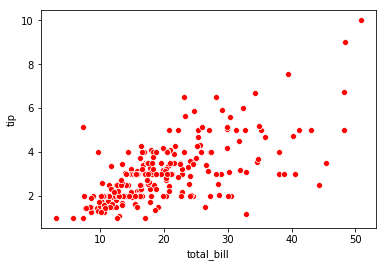

In [27]:
%matplotlib inline
sns.scatterplot(x=tips["total_bill"], y=tips["tip"], color='red')